In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.9 MB/s

In [ ]:
!pip install pytorch-gradcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 39.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5249 sha256=4dc77b0b4ff672e23c47301db4ead86f65fd7a2011886861348a747499ca0dbe
  Stored in directory: /root/.cache/pip/wheels/20/d6/4e/1ac02c54faee563b4d06015456c6c5d85550dcec878740f37d
Successfully built pytorch-gradcam


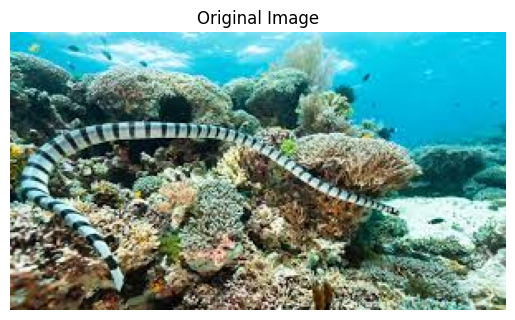

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
# Load and preprocess the image
image = Image.open('/content/sea snake.jpeg').convert('RGB')
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Define preprocessing transform for ResNet
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
x_orig = transform(image).unsqueeze(0)  # (1, 3, 224, 224)
x_adv = x_orig.clone().detach().requires_grad_(False)

# Load pretrained model
model = models.resnet18(pretrained=True).eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
x_adv = x_adv.to(device)
x_orig = x_orig.to(device)


In [ ]:
import urllib

with torch.no_grad():
    outputs = model(x_orig)
    probs = torch.nn.functional.softmax(outputs[0], dim=0)
    top5 = torch.topk(probs, 5)
print(top5)
# Step 7: Get ImageNet label names
labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_labels = urllib.request.urlopen(labels_url).read().decode("utf-8").split("\n")
print("Top-5 Predictions:")
for idx in range(5):
    class_idx = top5.indices[idx].item()
    confidence = top5.values[idx].item()
    class_name = imagenet_labels[class_idx]
    print(f"{idx+1}. {class_name} ({confidence:.4f})")


torch.return_types.topk(
values=tensor([9.6419e-01, 2.5250e-02, 8.7924e-03, 7.1192e-04, 3.4075e-04],
       device='cuda:0'),
indices=tensor([ 65, 973, 390,   5, 392], device='cuda:0'))
Top-5 Predictions:
1. sea snake (0.9642)
2. coral reef (0.0253)
3. eel (0.0088)
4. electric ray (0.0007)
5. rock beauty (0.0003)


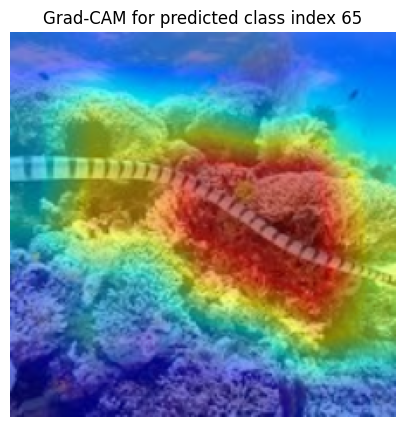

In [ ]:
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return (img_tensor.squeeze().cpu() * std + mean).clamp(0, 1).permute(1, 2, 0).numpy()
input_rgb = unnormalize(x_orig)

with torch.no_grad():
    output = model(x_orig)
    pred_class = torch.argmax(output, dim=1).item()

from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# Compute CAM
targets = [ClassifierOutputTarget(pred_class)]
grayscale_cam = cam(input_tensor=x_orig, targets=targets)[0]  # (H, W)
cam_image = show_cam_on_image(input_rgb, grayscale_cam, use_rgb=True)

# Show Grad-CAM
plt.figure(figsize=(10, 5))
plt.imshow(cam_image)
plt.title(f"Grad-CAM for predicted class index {pred_class}")
plt.axis('off')
plt.show()


In [ ]:
# Predict target class
with torch.no_grad():
    pred_logits = model(x_adv)
    target_label = torch.argmax(pred_logits, dim=1).item()

# Compute Grad-CAM
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(target_label)]
grayscale_cam = cam(input_tensor=x_adv, targets=targets)[0]  # (224, 224)

# Prepare cam_mask
cam_mask = torch.from_numpy(grayscale_cam).unsqueeze(0).unsqueeze(0).float().to(device)  # (1, 1, H, W)
cam_mask = cam_mask / cam_mask.max()


In [ ]:
def objective_fn(x_input):
    with torch.no_grad():
        probs = torch.nn.functional.softmax(model(x_input), dim=1)
        return probs[0, target_label].item()


In [ ]:
import torch.nn.functional as F
import torch.nn as nn

def nes_gradient_estimate_weighted(x, objective_fn, cam_mask, sigma=0.001, n_samples=50):
    """
    NES gradient estimation with Grad-CAM weighting.

    Args:
        x (Tensor): input image (1, C, H, W)
        objective_fn (function): function that returns a scalar objective
        cam_mask (Tensor): (1, 1, H, W) Grad-CAM heatmap, normalized in [0, 1]
        sigma (float): noise std
        n_samples (int): NES samples

    Returns:
        grad_estimate (Tensor): weighted NES gradient estimate
    """
    grads = torch.zeros_like(x)
    for _ in range(n_samples // 2):  # Antithetic sampling
        u = torch.randn_like(x)
        f_pos = objective_fn((x + sigma * u).clamp(0, 1))
        f_neg = objective_fn((x - sigma * u).clamp(0, 1))
        grads += (f_pos - f_neg) * u

    grad_estimate = grads / (sigma * n_samples)

    # Resize CAM mask and apply to each channel
    cam_mask_resized = F.interpolate(cam_mask, size=x.shape[2:], mode='bilinear', align_corners=False)
    if cam_mask_resized.shape[1] == 1:
        cam_mask_resized = cam_mask_resized.repeat(1, 3, 1, 1)  # match channels

    # Apply CAM weighting
    grad_estimate = grad_estimate * cam_mask_resized.to(x.device)

    return grad_estimate


In [ ]:
grad = nes_gradient_estimate_weighted(x_adv, objective_fn, cam_mask, sigma=0.005, n_samples=50)

print("Estimated gradient shape:", grad.shape)
print("Gradient stats → mean:", grad.mean().item(), " | std:", grad.std().item())

Estimated gradient shape: torch.Size([1, 3, 224, 224])
Gradient stats → mean: -0.00023214687826111913  | std: 0.06987183541059494


# Utility functions


In [ ]:
import torch.nn.functional as F

def query_model(image_tensor, topk=5, return_probs=True):
    """
    image_tensor: shape (1, 3, 299, 299), already preprocessed
    return_probs=True → return softmax probabilities (QL, PI)
    return_probs=False → return top-k labels (LO)
    """
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        logits = model(image_tensor)
        if return_probs:
            probs = F.softmax(logits, dim=1)
            return probs.cpu().squeeze()
        else:
            topk_indices = torch.topk(logits, k=topk, dim=1).indices.cpu().squeeze()
            return topk_indices


In [ ]:
def clip(x_adv, x_orig, epsilon):
    """
    Clips the adversarial example to be within epsilon of the original under L∞ norm.
    Args:
        x_adv (Tensor): adversarial image (B, C, H, W)
        x_orig (Tensor): original image (B, C, H, W)
        epsilon (float): max allowed perturbation
    Returns:
        Tensor: clipped image
    """
    return torch.clamp(x_adv, x_orig - epsilon, x_orig + epsilon).clamp(0, 1)

def rank(y, probs):
    """
    Returns the rank (0-based) of the true label y in the probability distribution.
    Args:
        y (int): target label index
        probs (Tensor): probability distribution (num_classes,)
    Returns:
        int: rank of y (0 = top1)
    """
    sorted_indices = torch.argsort(probs, descending=True)
    return (sorted_indices == y).nonzero(as_tuple=True)[0].item()

def topk_labels(probs, k=5):
    """
    Returns the indices of the top-k probabilities.
    Args:
        probs (Tensor): probability distribution (num_classes,)
        k (int): number of top classes
    Returns:
        Tensor: indices of top-k predictions
    """
    return torch.topk(probs, k).indices

import json
import requests

def label_to_name(idx):
    """
    Converts ImageNet class index (0–999) to human-readable label.
    Requires downloading the index-to-name mapping if not already present.
    """
    if not hasattr(label_to_name, "idx_to_label"):
        url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
        response = requests.get(url)
        label_to_name.idx_to_label = response.text.strip().split("\n")

    return label_to_name.idx_to_label[idx]


# regular gradient update

In [ ]:
def nes_gradient_estimate(x, objective_fn, sigma=0.001, n_samples=50):
    """
    Estimate the gradient of an objective function using NES.

    Args:
        x (Tensor): current adversarial example (1, C, H, W)
        objective_fn (callable): function that takes an image tensor and returns a scalar (probability or proxy score)
        sigma (float): standard deviation of Gaussian noise
        n_samples (int): number of perturbation directions (half will be negated for antithetic sampling)

    Returns:
        Tensor: estimated gradient (same shape as x)
    """
    grads = torch.zeros_like(x)
    for _ in range(n_samples // 2):  # use antithetic sampling
        u = torch.randn_like(x)
        f_pos = objective_fn((x + sigma * u).clamp(0, 1))
        f_neg = objective_fn((x - sigma * u).clamp(0, 1))
        grads += (f_pos - f_neg) * u

    grad_estimate = grads / (sigma * n_samples)
    return grad_estimate


def ql_objective_fn(x):
    """Returns probability of the target class"""
    probs = query_model(x, return_probs=True)
    return probs[target_label].item()



# Query limited updated

In [ ]:
def query_limited_attack(
    x_orig, target_label, epsilon, sigma, step_size, n_samples, max_queries, query_model_fn, cam_mask=None
):
    """
    Query-limited attack using NES + PGD.

    Args:
        x_orig (Tensor): original image (1, C, H, W)
        target_label (int): adversarial target class
        epsilon (float): max L∞ norm
        sigma (float): NES noise std
        step_size (float): PGD step size
        n_samples (int): number of NES samples per gradient step
        max_queries (int): query budget
        query_model_fn (function): returns softmax probabilities for a given image

    Returns:
        x_adv (Tensor): final adversarial example
        success (bool): whether target was achieved
        num_queries (int): total queries used

    """



    x_adv = x_orig.clone().detach()
    num_queries = 0
    success = False

    while num_queries < max_queries:
        # Compute NES gradient
        def objective_fn(x):
            probs = query_model_fn(x, return_probs=True)
            return probs[target_label].item()
        if cam_mask is not None:
            grad = nes_gradient_estimate_weighted(x_adv, objective_fn, cam_mask, sigma, n_samples)
        else:
            grad = nes_gradient_estimate(x_adv, objective_fn, sigma, n_samples)
        # grad = nes_gradient_estimate(x_adv, objective_fn, sigma=sigma, n_samples=n_samples)
        num_queries += n_samples  # NES queries

        # PGD update
        x_adv = x_adv + step_size * torch.sign(grad)
        x_adv = clip(x_adv, x_orig, epsilon)

        # Check success
        probs = query_model_fn(x_adv, return_probs=True)
        num_queries += 1

        top5 = torch.topk(probs, k=5).indices.tolist()
        if target_label in top5:
            success = True
            break
        # pred_label = torch.argmax(probs).item()

        # if pred_label == target_label:
        #     success = True
        #     break

    return x_adv, success, num_queries


In [ ]:
# Generate Grad-CAM mask as before
cam = GradCAM(model=model, target_layers=[model.layer4[-1]])
grayscale_cam = cam(input_tensor=x_adv, targets=[ClassifierOutputTarget(target_label)])[0]
cam_mask = torch.from_numpy(grayscale_cam).unsqueeze(0).unsqueeze(0).float().to(device)
cam_mask = cam_mask / cam_mask.max()


In [ ]:
x_adv, success, queries = query_limited_attack(
    x_orig=x_orig,
    target_label=target_label,
    epsilon=0.05,
    sigma=0.005,
    step_size=0.01,
    n_samples=50,
    max_queries=1000,
    query_model_fn=query_model,
    cam_mask=cam_mask   # 💡 Grad-CAM integrated!
)


In [ ]:
results = {}

for use_cam in [False, True]:
    cam_input = cam_mask if use_cam else None

    x_adv, success, queries = query_limited_attack(
        x_orig=x_orig,
        target_label=target_label,
        epsilon=0.3,
        sigma=0.06,
        step_size=0.1,
        n_samples=30,
        max_queries=1000,
        query_model_fn=query_model,
        cam_mask=cam_input
    )

    results["with_CAM" if use_cam else "baseline"] = {
        "success": success,
        "queries": queries,
        "x_adv": x_adv.detach().cpu()
    }

print(results)


{'baseline': {'success': True, 'queries': 31, 'x_adv': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2652],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1111],
          [0.0000, 0.0426, 0.0000,  ..., 0.0000, 0.0000, 0.4652]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.0000, 0.0000, 0.0776,  ..., 0.0000, 0.1402, 0.8829],
          [0.0000, 0.0776, 0.0776,  ..., 0.0000, 0.0000, 0.5254],
          [0.0000, 0.0352, 0.0000,  ..., 0.2702, 0.0000, 0.9004]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.00

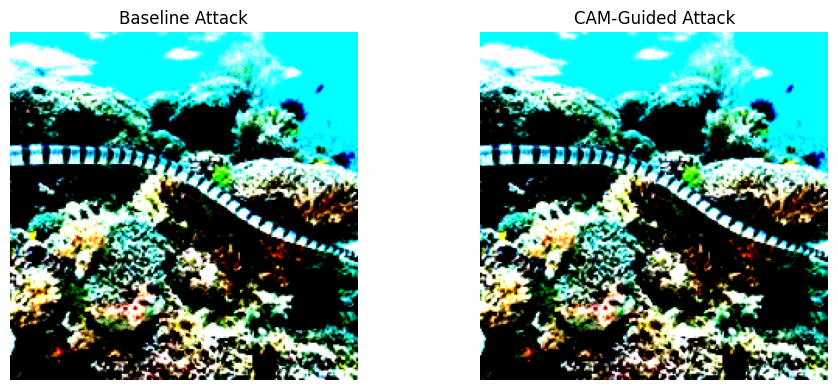

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(results["baseline"]["x_adv"].squeeze().permute(1, 2, 0))
plt.title("Baseline Attack")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(results["with_CAM"]["x_adv"].squeeze().permute(1, 2, 0))
plt.title("CAM-Guided Attack")
plt.axis("off")

plt.tight_layout()
plt.show()


# Partial info updated

In [ ]:
def partial_info_attack(
    x_orig, x_target, target_label,
    epsilon_init=1.0, epsilon_final=0.05, decay_rate=0.98,
    shrink_steps=100,
    sigma=0.005, step_size=0.01, n_samples=50, max_queries=2000,
    query_model_fn=query_model, topk=5, cam_mask=None
):
    """
    Partial-Information attack as per the paper.
    Works only with access to top-k predictions (not probabilities).

    Args:
        x_orig: original image tensor (1, C, H, W)
        x_target: image that model classifies as target_label
        target_label: target class index
        epsilon_init: initial perturbation (large)
        epsilon_final: minimal perturbation allowed
        decay_rate: how fast epsilon shrinks
        shrink_steps: how many steps for shrinking
        topk: number of labels attacker sees (partial-info setting)
        Other args as defined previously...

    Returns:
        x_adv: final adversarial example
        success: whether target_label is in top-k
        num_queries: total queries used
    """


    x_adv = x_target.clone().detach()
    epsilon = epsilon_init
    num_queries = 0

    # === Stage 1: Epsilon Shrinking ===
    for i in range(shrink_steps):
        topk_preds = query_model_fn(x_adv, return_probs=False).tolist()
        num_queries += 1

        if target_label in topk_preds:
            # shrink epsilon, move x_adv closer to x_orig
            direction = torch.sign(x_adv - x_orig)
            x_adv = x_adv - step_size * direction
            x_adv = clip(x_adv, x_orig, epsilon)
            epsilon = max(epsilon * decay_rate, epsilon_final)
        else:
            print(f"Target dropped out of top-{topk} during shrinking (step {i})")
            break

    # === Stage 2: NES-based gradient ascent ===
    def proxy_objective(x):
        preds = query_model_fn(x, return_probs=False).tolist()
        num_queries_ = 1
        if target_label in preds:
            # Better rank = higher reward (invert rank)
            rank_score = topk - preds.index(target_label)
            return rank_score
        else:
            return 0

    # NES loop after shrinking
    for _ in range(20):  # fixed PGD steps
        # grad = nes_gradient_estimate(x_adv, proxy_objective, sigma=sigma, n_samples=n_samples)
        if cam_mask is not None:
            grad = nes_gradient_estimate_weighted(x_adv, objective_fn, cam_mask, sigma, n_samples)
        else:
            grad = nes_gradient_estimate(x_adv, objective_fn, sigma, n_samples)
        num_queries += n_samples
        x_adv = x_adv + step_size * torch.sign(grad)
        x_adv = clip(x_adv, x_orig, epsilon_final)

        # Check top-k
        topk_preds = query_model_fn(x_adv, return_probs=False).tolist()
        num_queries += 1
        if target_label in topk_preds:
            success = True
        else:
            success = False
            break

    return x_adv, success, num_queries


In [ ]:
def evaluate_attack(attack_fn, x_orig, x_target, target_label, cam_mask, **kwargs):
    results = {}

    for use_cam in [False, True]:
        cam_input = cam_mask if use_cam else None

        x_adv, success, queries = attack_fn(
            x_orig=x_orig,
            x_target=x_target,
            target_label=target_label,
            cam_mask=cam_input,
            **kwargs
        )

        label = "with_CAM" if use_cam else "baseline"
        results[label] = {
            "success": success,
            "queries": queries,
            "x_adv": x_adv.detach().cpu()
        }

    return results

def visualize_results(results, title):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 4))
    for i, label in enumerate(["baseline", "with_CAM"]):
        img = results[label]["x_adv"].squeeze().permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # normalize
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(f"{label}\nSuccess: {results[label]['success']} | Queries: {results[label]['queries']}")
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [ ]:
image = Image.open('/content/watersnake.jpeg').convert('RGB')
x_target = transform(image).unsqueeze(0)  # (1, 3, 224, 224)
x_target = x_target.to(device)

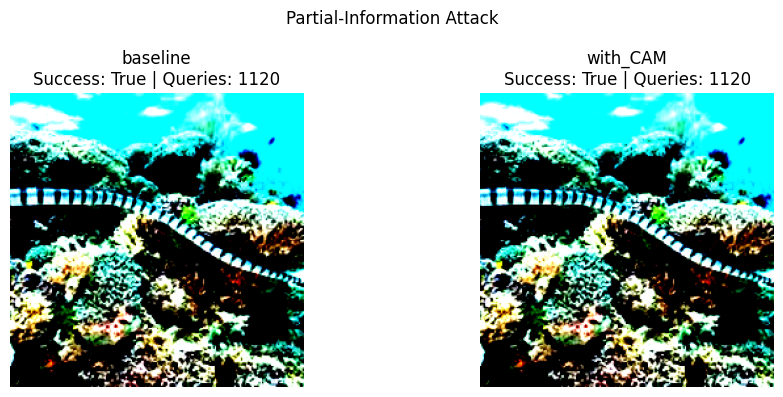

In [ ]:
results_pi = evaluate_attack(
    partial_info_attack,
    x_orig=x_orig,
    x_target=x_target,
    target_label=target_label,
    cam_mask=cam_mask,
    epsilon_init=1.0,
    epsilon_final=0.05,
    decay_rate=0.98,
    shrink_steps=100,
    sigma=0.005,
    step_size=0.01,
    n_samples=50,
    max_queries=2000,
    query_model_fn=query_model,
    topk=5
)

visualize_results(results_pi, "Partial-Information Attack")


# Label only updated

In [ ]:
def label_only_attack(
    x_orig, x_target, target_label,
    epsilon_init=1.0, epsilon_final=0.05, decay_rate=0.98, shrink_steps=100,
    sigma=0.005, step_size=0.01, n_samples=50, max_queries=2000,
    query_model_fn=query_model, topk=5, cam_mask=None
):
    """
    Label-only black-box adversarial attack.
    Assumes only top-k class labels are visible.
    """

    x_adv = x_target.clone().detach()
    epsilon = epsilon_init
    num_queries = 0

    # === Phase 1: Shrinking epsilon (just like PI)
    for i in range(shrink_steps):
        topk_preds = query_model_fn(x_adv, return_probs=False).tolist()
        num_queries += 1

        if target_label in topk_preds:
            direction = torch.sign(x_adv - x_orig)
            x_adv = x_adv - step_size * direction
            x_adv = clip(x_adv, x_orig, epsilon)
            epsilon = max(epsilon * decay_rate, epsilon_final)
        else:
            print(f"Target dropped from top-{topk} during shrinking.")
            break

    # === Phase 2: Proxy optimization (based on rank)
    def proxy_objective(x):
        preds = query_model_fn(x, return_probs=False).tolist()
        if target_label in preds:
            rank_score = topk - preds.index(target_label)
        else:
            rank_score = 0
        return rank_score  # higher is better

    for _ in range(20):  # fixed PGD steps
        # grad = nes_gradient_estimate(x_adv, proxy_objective, sigma=sigma, n_samples=n_samples)
        if cam_mask is not None:
            grad = nes_gradient_estimate_weighted(x_adv, objective_fn, cam_mask, sigma, n_samples)
        else:
            grad = nes_gradient_estimate(x_adv, objective_fn, sigma, n_samples)
        num_queries += n_samples

        x_adv = x_adv + step_size * torch.sign(grad)
        x_adv = clip(x_adv, x_orig, epsilon_final)

        preds = query_model_fn(x_adv, return_probs=False).tolist()
        num_queries += 1
        if target_label in preds:
            success = True
        else:
            success = False
            break

    return x_adv, success, num_queries


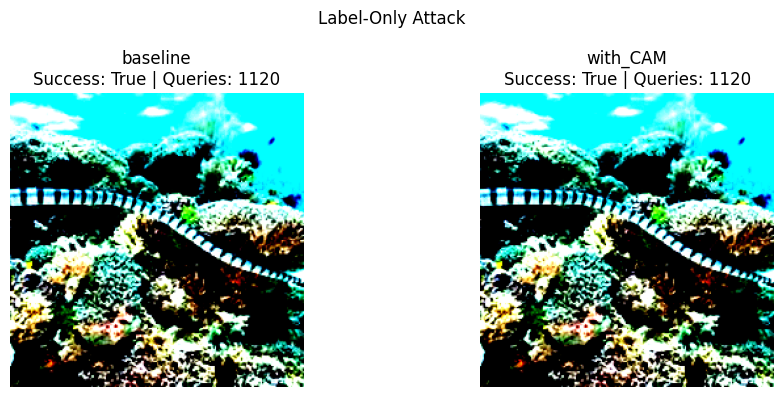

In [ ]:
results_lo = evaluate_attack(
    label_only_attack,
    x_orig=x_orig,
    x_target=x_target,
    target_label=target_label,
    cam_mask=cam_mask,
    epsilon_init=1.0,
    epsilon_final=0.05,
    decay_rate=0.98,
    shrink_steps=100,
    sigma=0.005,
    step_size=0.01,
    n_samples=50,
    max_queries=2000,
    query_model_fn=query_model,
    topk=5
)

visualize_results(results_lo, "Label-Only Attack")


In [ ]:
def nes_gradient_estimate_patchwise_weighted(x, objective_fn, cam_mask,
                                             patch_size=32, sigma=0.001, n_samples=50):
    """
    NES gradient estimation where perturbations are applied patch-wise.

    Args:
        x (Tensor): input image (1, 3, H, W)
        objective_fn (callable): returns scalar objective
        cam_mask (Tensor): (1, 1, H, W) normalized CAM heatmap
        patch_size (int): size of square patch (e.g., 32)
        sigma (float): noise std
        n_samples (int): number of NES samples

    Returns:
        grad_estimate (Tensor): (1, 3, H, W) NES gradient
    """
    B, C, H, W = x.shape
    assert H % patch_size == 0 and W % patch_size == 0, "Image size must be divisible by patch size"
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size

    grads = torch.zeros_like(x)

    for _ in range(n_samples // 2):
        # Random noise per patch
        patch_noise = torch.randn(1, C, num_patches_h, num_patches_w, device=x.device)

        # Upsample noise to full image size by repeating
        noise = patch_noise.repeat_interleave(patch_size, dim=2).repeat_interleave(patch_size, dim=3)

        f_pos = objective_fn((x + sigma * noise).clamp(0, 1))
        f_neg = objective_fn((x - sigma * noise).clamp(0, 1))

        grads += (f_pos - f_neg) * noise

    grad_estimate = grads / (sigma * n_samples)

    # Resize and apply CAM mask
    cam_mask_resized = F.interpolate(cam_mask, size=(H, W), mode='bilinear', align_corners=False)
    if cam_mask_resized.shape[1] == 1:
        cam_mask_resized = cam_mask_resized.repeat(1, 3, 1, 1)

    return grad_estimate * cam_mask_resized


In [ ]:
def query_limited_attack_patchwise(
    x_orig, target_label, epsilon, sigma, step_size, n_samples, max_queries,
    query_model_fn, cam_mask=None, patch_size=32
):
    x_adv = x_orig.clone().detach()
    num_queries = 0
    success = False

    def objective_fn(x):
        probs = query_model_fn(x, return_probs=True)
        return probs[target_label].item()

    while num_queries < max_queries:
        if cam_mask is not None:
            grad = nes_gradient_estimate_patchwise_weighted(x_adv, objective_fn, cam_mask, patch_size, sigma, n_samples)
        else:
            grad = nes_gradient_estimate_patchwise_weighted(x_adv, objective_fn, torch.ones_like(x_orig[:, :1]), patch_size, sigma, n_samples)

        num_queries += n_samples

        x_adv = x_adv + step_size * torch.sign(grad)
        x_adv = clip(x_adv, x_orig, epsilon)

        probs = query_model_fn(x_adv, return_probs=True)
        num_queries += 1
        top5 = torch.topk(probs, k=5).indices.tolist()
        if target_label in top5:
            success = True
            break

    return x_adv, success, num_queries

In [ ]:
objective_fn(x_orig)

0.9641851186752319

In [ ]:
x_adv, success, queries = query_limited_attack_patchwise(
    x_orig=x_orig,
    target_label=target_label,
    epsilon=0.05,
    sigma=0.005,
    step_size=0.01,
    n_samples=50,
    max_queries=1000,
    query_model_fn=query_model,
    cam_mask=cam_mask,       # optional Grad-CAM mask
    patch_size=32            # patch size (divides image dimensions)
)


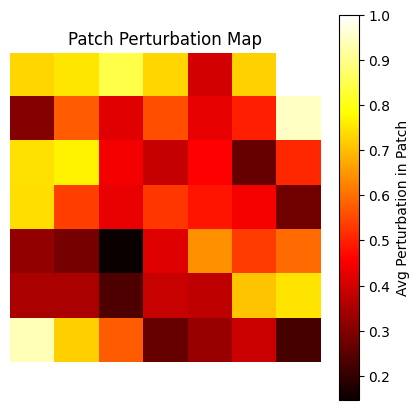

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_patchwise_perturbation(x_orig, x_adv, patch_size=32, title="Patch Perturbation Map"):
    diff = (x_adv - x_orig).abs().sum(dim=1, keepdim=True)  # (1, 1, H, W)
    diff = diff.squeeze().cpu().numpy()

    # Sum per patch
    H, W = diff.shape
    patch_map = np.zeros((H // patch_size, W // patch_size))
    for i in range(0, H, patch_size):
        for j in range(0, W, patch_size):
            patch_value = diff[i:i+patch_size, j:j+patch_size].mean()
            patch_map[i // patch_size, j // patch_size] = patch_value

    # Normalize and visualize
    patch_map = patch_map / patch_map.max()

    plt.figure(figsize=(5, 5))
    plt.imshow(patch_map, cmap="hot", interpolation="nearest")
    plt.title(title)
    plt.colorbar(label="Avg Perturbation in Patch")
    plt.axis("off")
    plt.show()

visualize_patchwise_perturbation(x_orig, x_adv, patch_size=32)

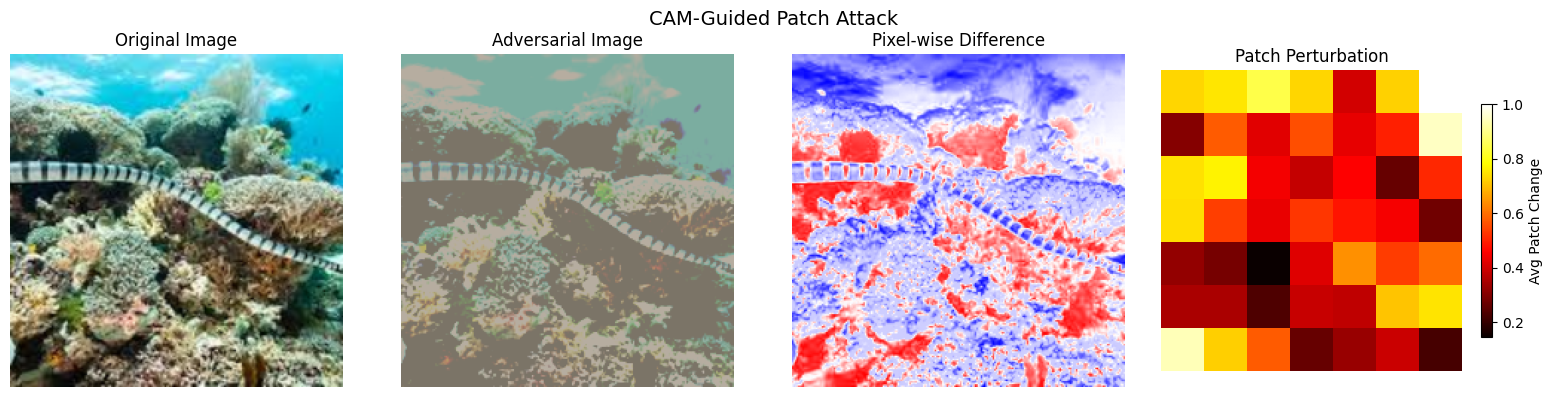

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def unnormalize(img_tensor):
    """Unnormalize tensor image (assumes ImageNet stats)"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(img_tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(img_tensor.device)
    return (img_tensor * std + mean).clamp(0, 1)

def visualize_patchwise_perturbation(x_orig, x_adv, patch_size=32, title="Patch Perturbation Map"):
    x_orig = x_orig.squeeze()
    x_adv = x_adv.squeeze()

    # Unnormalize for display
    x_orig_disp = unnormalize(x_orig).permute(1, 2, 0).cpu().numpy()
    x_adv_disp = unnormalize(x_adv).permute(1, 2, 0).cpu().numpy()

    # Compute absolute difference heatmap
    diff_map = (x_adv - x_orig).abs().sum(dim=0).cpu().numpy()

    # Patch-level difference
    # H, W = diff_map.shape[1], diff_map.shape[2] if diff_map.ndim == 3 else diff_map.shape
    H, W = diff_map.shape
    patch_map = np.zeros((H // patch_size, W // patch_size))
    for i in range(0, H, patch_size):
        for j in range(0, W, patch_size):
            patch_value = diff_map[i:i+patch_size, j:j+patch_size].mean()
            patch_map[i // patch_size, j // patch_size] = patch_value

    patch_map = patch_map / patch_map.max()

    # Plot all views
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    axs[0].imshow(x_orig_disp)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(x_adv_disp)
    axs[1].set_title("Adversarial Image")
    axs[1].axis("off")

    axs[2].imshow((x_adv_disp - x_orig_disp).mean(axis=2), cmap='bwr')
    axs[2].set_title("Pixel-wise Difference")
    axs[2].axis("off")

    im = axs[3].imshow(patch_map, cmap="hot", interpolation="nearest")
    axs[3].set_title("Patch Perturbation")
    axs[3].axis("off")
    fig.colorbar(im, ax=axs[3], shrink=0.7, label="Avg Patch Change")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()



visualize_patchwise_perturbation(x_orig, x_adv, patch_size=32, title="CAM-Guided Patch Attack")


In [ ]:
def compare_query_efficiency(x_orig, target_label, cam_mask):
    methods = {
        "Pixel-wise NES": {
            "fn": query_limited_attack,
            "extra_args": {}
        },
        "Patch-wise NES": {
            "fn": query_limited_attack_patchwise,
            "extra_args": {"patch_size": 32}
        },
        "CAM + Patch-wise NES": {
            "fn": query_limited_attack_patchwise,
            "extra_args": {"patch_size": 32, "cam_mask": cam_mask}
        }
    }

    results = {}
    for name, method in methods.items():
        print(f"\n Running: {name}")
        attack_fn = method["fn"]
        extra_args = method["extra_args"]

        x_adv, success, queries = attack_fn(
            x_orig=x_orig,
            target_label=target_label,
            epsilon=0.05,
            sigma=0.005,
            step_size=0.01,
            n_samples=50,
            max_queries=1000,
            query_model_fn=query_model,
            **extra_args  # only passed to methods that expect them
        )

        results[name] = {
            "success": success,
            "queries": queries,
            "x_adv": x_adv.detach().cpu()
        }

    return results


In [ ]:
def plot_query_comparison(results):
    names = list(results.keys())
    queries = [results[name]["queries"] for name in names]
    colors = ["gray", "skyblue", "orangered"]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(names, queries, color=colors)
    for bar, q in zip(bars, queries):
        plt.text(bar.get_x() + bar.get_width() / 2, q + 5, str(q), ha='center', va='bottom')
    plt.title("Query Efficiency: Pixel vs Patch vs CAM+Patch")
    plt.ylabel("Number of Queries")
    plt.ylim(0, max(queries) + 50)
    plt.xticks(rotation=15)
    plt.show()



 Running: Pixel-wise NES

 Running: Patch-wise NES

 Running: CAM + Patch-wise NES


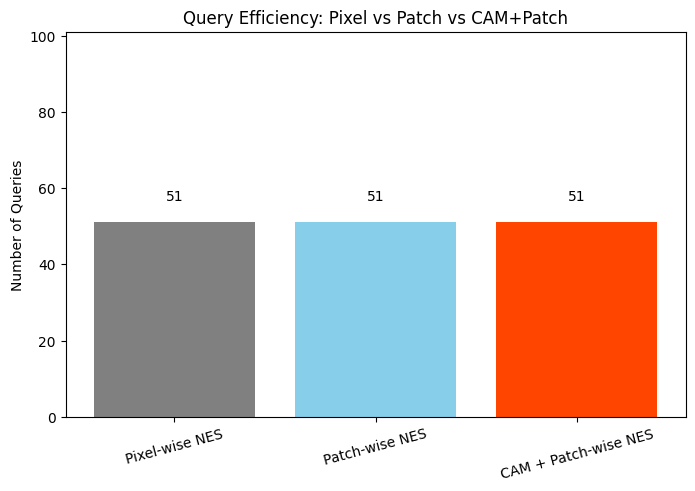

In [ ]:
results = compare_query_efficiency(x_orig, target_label, cam_mask)
plot_query_comparison(results)


In [ ]:
def partial_info_attack_patchwise(
    x_orig, x_target, target_label, epsilon_init=1.0, epsilon_final=0.05, decay_rate=0.98,
    shrink_steps=100, sigma=0.005, step_size=0.01, n_samples=50, max_queries=2000,
    query_model_fn=None, topk=5, cam_mask=None, patch_size=32
):
    x_adv = x_target.clone().detach()
    epsilon = epsilon_init
    num_queries = 0

    for i in range(shrink_steps):
        # Make the output of query_model iterable by converting it to a list
        topk_preds = query_model_fn(x_adv, return_probs=False).tolist()

        # In case topk_preds is a single integer wrap it in a list for checking
        topk_preds = [topk_preds] if isinstance(topk_preds, int) else topk_preds

        num_queries += 1

        if target_label in topk_preds:
            direction = torch.sign(x_adv - x_orig)
            x_adv = x_adv - step_size * direction
            x_adv = clip(x_adv, x_orig, epsilon)
            epsilon = max(epsilon * decay_rate, epsilon_final)
        else:
            break

    def proxy_objective(x):
        # make sure the query_model output is a list, then get the first element (which is also a list of predictions)
        preds = query_model_fn(x, return_probs=False).tolist()
        preds = preds[0] if isinstance(preds[0], list) else preds

        return topk - preds.index(target_label) if target_label in preds else 0

    for _ in range(20):
        if cam_mask is not None:
            grad = nes_gradient_estimate_patchwise_weighted(x_adv, proxy_objective, cam_mask, patch_size, sigma, n_samples)
        else:
            grad = nes_gradient_estimate_patchwise_weighted(x_adv, proxy_objective, torch.ones_like(x_orig[:, :1]), patch_size, sigma, n_samples)

        num_queries += n_samples
        x_adv = x_adv + step_size * torch.sign(grad)
        x_adv = clip(x_adv, x_orig, epsilon_final)

        # make sure the query_model output is a list, then get the first element (which is also a list of predictions)
        preds = query_model_fn(x_adv, return_probs=False).tolist()
        preds = preds[0] if isinstance(preds[0], list) else preds

        num_queries += 1
        if target_label not in preds:
            return x_adv, False, num_queries

    return x_adv, True, num_queries

In [ ]:
def visualize_patchwise_nocam_perturbation(x_orig, x_adv, patch_size=32, title="Patchwise NES Perturbation Map"):
    x_orig = x_orig.squeeze()
    x_adv = x_adv.squeeze()

    x_orig_disp = unnormalize(x_orig).permute(1, 2, 0).cpu().numpy()
    x_adv_disp = unnormalize(x_adv).permute(1, 2, 0).cpu().numpy()

    diff_map = (x_adv - x_orig).abs().sum(dim=0).cpu().numpy()

    H, W = diff_map.shape
    patch_map = np.zeros((H // patch_size, W // patch_size))
    for i in range(0, H, patch_size):
        for j in range(0, W, patch_size):
            patch_value = diff_map[i:i+patch_size, j:j+patch_size].mean()
            patch_map[i // patch_size, j // patch_size] = patch_value

    patch_map = patch_map / patch_map.max()

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    axs[0].imshow(x_orig_disp)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(x_adv_disp)
    axs[1].set_title("Adversarial Image")
    axs[1].axis("off")

    axs[2].imshow((x_adv_disp - x_orig_disp).mean(axis=2), cmap='bwr')
    axs[2].set_title("Pixel-wise Difference")
    axs[2].axis("off")

    im = axs[3].imshow(patch_map, cmap="YlGn", interpolation="nearest")
    axs[3].set_title("Patch Perturbation")
    axs[3].axis("off")
    fig.colorbar(im, ax=axs[3], shrink=0.7, label="Avg Patch Change")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


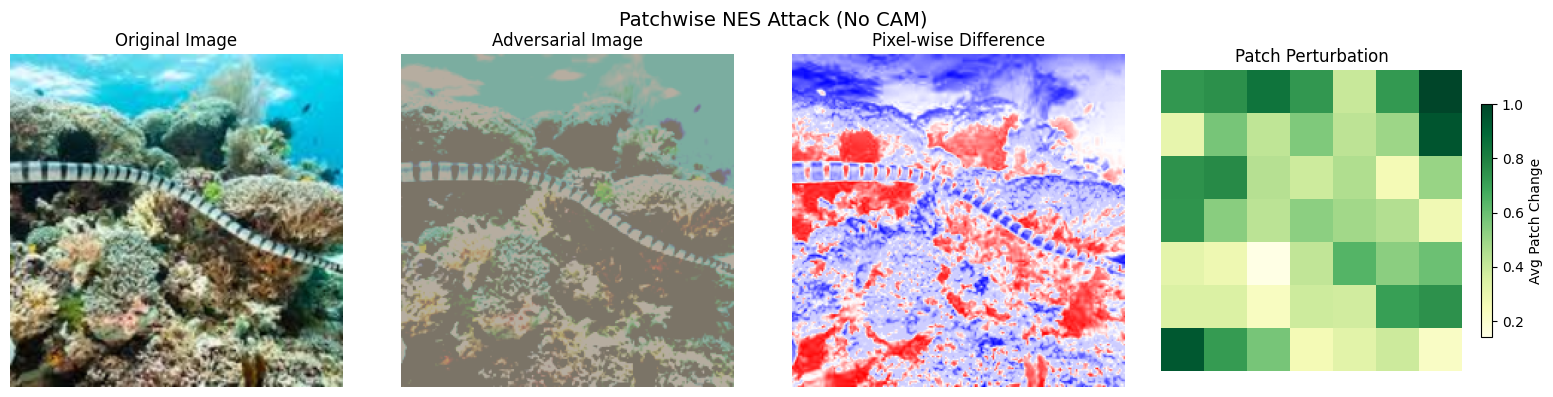

In [ ]:
# Run the partial info patchwise attack (without CAM guidance)
x_adv_result, success, queries = partial_info_attack_patchwise(
    x_orig=x_orig,
    x_target=x_orig,  # start from original image
    target_label=target_label,
    epsilon_init=1.0,
    epsilon_final=0.05,
    decay_rate=0.98,
    shrink_steps=100,
    sigma=0.005,
    step_size=0.01,
    n_samples=50,
    max_queries=2000,
    query_model_fn=query_model,  # assuming this is already defined and working
    topk=5,
    cam_mask=None,  # no CAM guidance
    patch_size=32
)

# Visualize the patch-wise perturbations
visualize_patchwise_nocam_perturbation(x_orig, x_adv_result, patch_size=32, title="Patchwise NES Attack (No CAM)")


In [ ]:
def compare_partial_info_attack(x_orig, x_target, target_label, cam_mask):
    methods = {
        "Patch-wise PI": {
            "fn": partial_info_attack_patchwise,
            "extra_args": {"patch_size": 32}
        },
        "CAM + Patch-wise PI": {
            "fn": partial_info_attack_patchwise,
            "extra_args": {"patch_size": 32, "cam_mask": cam_mask}
        }
    }

    results = {}
    for name, method in methods.items():
        print(f"\n  Running: {name}")
        attack_fn = method["fn"]
        extra_args = method["extra_args"]

        x_adv, success, queries = attack_fn(
            x_orig=x_orig,
            x_target=x_target,
            target_label=target_label,
            epsilon_init=1.0,
            epsilon_final=0.05,
            decay_rate=0.98,
            shrink_steps=100,
            sigma=0.005,
            step_size=0.01,
            n_samples=50,
            max_queries=2000,
            query_model_fn=query_model,
            topk=5,
            **extra_args
        )

        results[name] = {
            "success": success,
            "queries": queries,
            "x_adv": x_adv.detach().cpu()
        }

    return results



  Running: Patch-wise PI

  Running: CAM + Patch-wise PI


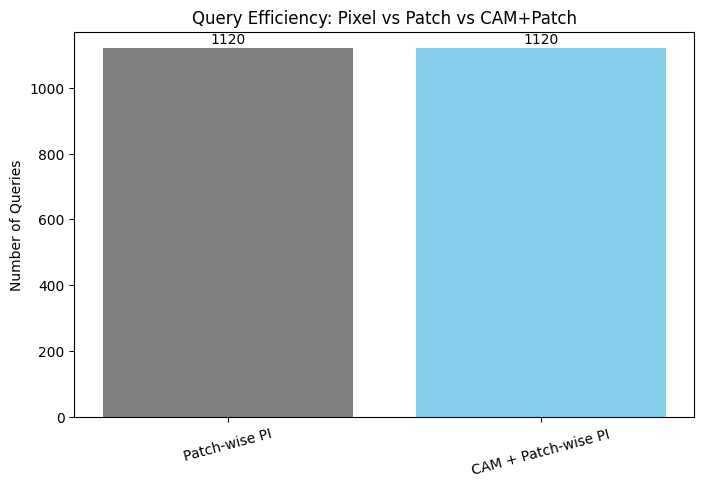

In [ ]:
results_pi = compare_partial_info_attack(x_orig, x_target, target_label, cam_mask)
plot_query_comparison(results_pi)


In [ ]:
def visualize_patchwise_labelonly_perturbation(x_orig, x_adv, patch_size=32, title="Label-Only Patch Perturbation Map"):
    x_orig = x_orig.squeeze()
    x_adv = x_adv.squeeze()

    x_orig_disp = unnormalize(x_orig).permute(1, 2, 0).cpu().numpy()
    x_adv_disp = unnormalize(x_adv).permute(1, 2, 0).cpu().numpy()

    diff_map = (x_adv - x_orig).abs().sum(dim=0).cpu().numpy()

    H, W = diff_map.shape
    patch_map = np.zeros((H // patch_size, W // patch_size))
    for i in range(0, H, patch_size):
        for j in range(0, W, patch_size):
            patch_value = diff_map[i:i+patch_size, j:j+patch_size].mean()
            patch_map[i // patch_size, j // patch_size] = patch_value

    patch_map = patch_map / patch_map.max()

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    axs[0].imshow(x_orig_disp)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(x_adv_disp)
    axs[1].set_title("Adversarial Image")
    axs[1].axis("off")

    axs[2].imshow((x_adv_disp - x_orig_disp).mean(axis=2), cmap='bwr')
    axs[2].set_title("Pixel-wise Difference")
    axs[2].axis("off")

    im = axs[3].imshow(patch_map, cmap="viridis", interpolation="nearest")
    axs[3].set_title("Patch Perturbation")
    axs[3].axis("off")
    fig.colorbar(im, ax=axs[3], shrink=0.7, label="Avg Patch Change")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


In [ ]:
def label_only_attack_patchwise(
    x_orig, x_target, target_label, epsilon_init=1.0, epsilon_final=0.05, decay_rate=0.98,
    shrink_steps=100, sigma=0.005, step_size=0.01, n_samples=50, max_queries=2000,
    query_model_fn=None, topk=5, cam_mask=None, patch_size=32
):
    x_adv = x_target.clone().detach()
    epsilon = epsilon_init
    num_queries = 0

    for i in range(shrink_steps):
        # Ensure topk_preds is a list
        topk_preds = query_model_fn(x_adv, return_probs=False).tolist()
        # If topk_preds is an int, make it a list
        if isinstance(topk_preds, int):
            topk_preds = [topk_preds]
        num_queries += 1

        if target_label in topk_preds:
            direction = torch.sign(x_adv - x_orig)
            x_adv = x_adv - step_size * direction
            x_adv = clip(x_adv, x_orig, epsilon)
            epsilon = max(epsilon * decay_rate, epsilon_final)
        else:
            break

    def proxy_objective(x):
        # Ensure preds is a list
        preds = query_model_fn(x, return_probs=False).tolist()
        # If preds is an int, make it a list
        if isinstance(preds, int):
            preds = [preds]
        return topk - preds.index(target_label) if target_label in preds else 0

    for _ in range(20):
        if cam_mask is not None:
            grad = nes_gradient_estimate_patchwise_weighted(x_adv, proxy_objective, cam_mask, patch_size, sigma, n_samples)
        else:
            grad = nes_gradient_estimate_patchwise_weighted(x_adv, proxy_objective, torch.ones_like(x_orig[:, :1]), patch_size, sigma, n_samples)

        num_queries += n_samples
        x_adv = x_adv + step_size * torch.sign(grad)
        x_adv = clip(x_adv, x_orig, epsilon_final)

        # Ensure preds is a list
        preds = query_model_fn(x_adv, return_probs=False).tolist()
        # If preds is an int, make it a list
        if isinstance(preds, int):
            preds = [preds]
        num_queries += 1
        if target_label not in preds:
            return x_adv, False, num_queries

    return x_adv, True, num_queries

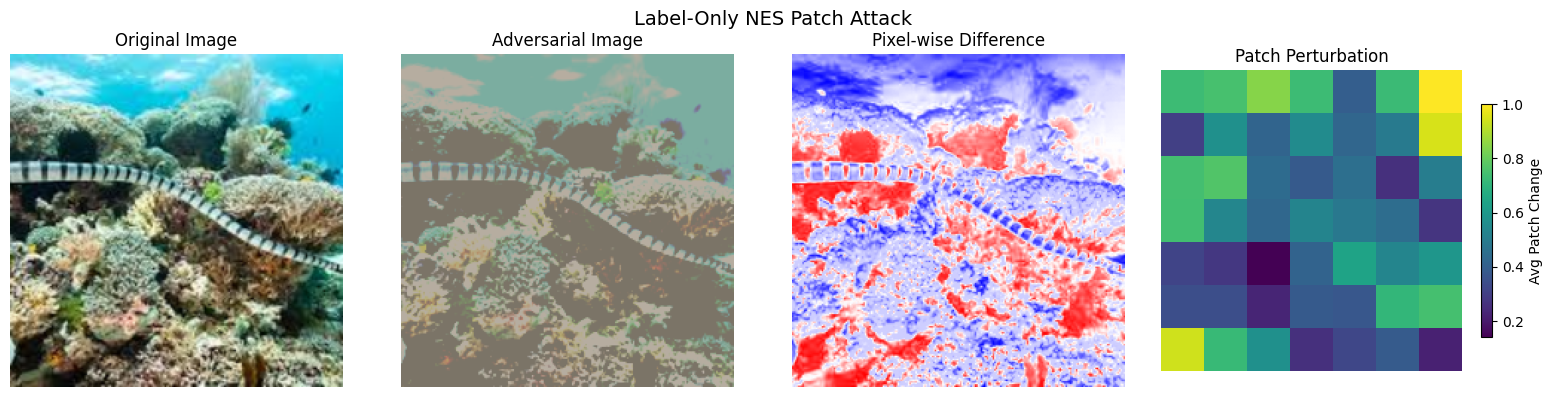

In [ ]:
# Run the label-only patchwise attack
x_adv_labelonly, success_labelonly, queries_labelonly = label_only_attack_patchwise(
    x_orig=x_orig,
    x_target=x_orig,  # starting from the original image
    target_label=target_label,
    epsilon_init=1.0,
    epsilon_final=0.05,
    decay_rate=0.98,
    shrink_steps=100,
    sigma=0.005,
    step_size=0.01,
    n_samples=50,
    max_queries=2000,
    query_model_fn=query_model,  # assuming this is your prediction function
    topk=5,
    cam_mask=None,  # label-only assumes no CAM
    patch_size=32
)

# Visualize the resulting perturbations
visualize_patchwise_labelonly_perturbation(
    x_orig,
    x_adv_labelonly,
    patch_size=32,
    title="Label-Only NES Patch Attack"
)


In [ ]:
def compare_label_only_attack(x_orig, x_target, target_label, cam_mask):
    methods = {
        "Patch-wise LO": {
            "fn": label_only_attack_patchwise,
            "extra_args": {"patch_size": 32}
        },
        "CAM + Patch-wise LO": {
            "fn": label_only_attack_patchwise,
            "extra_args": {"patch_size": 32, "cam_mask": cam_mask}
        }
    }

    results = {}
    for name, method in methods.items():
        print(f"\n Running: {name}")
        attack_fn = method["fn"]
        extra_args = method["extra_args"]

        x_adv, success, queries = attack_fn(
            x_orig=x_orig,
            x_target=x_target,
            target_label=target_label,
            epsilon_init=1.0,
            epsilon_final=0.05,
            decay_rate=0.98,
            shrink_steps=100,
            sigma=0.005,
            step_size=0.01,
            n_samples=50,
            max_queries=2000,
            query_model_fn=query_model,
            topk=5,
            **extra_args
        )

        results[name] = {
            "success": success,
            "queries": queries,
            "x_adv": x_adv.detach().cpu()
        }

    return results



 Running: Patch-wise LO

 Running: CAM + Patch-wise LO


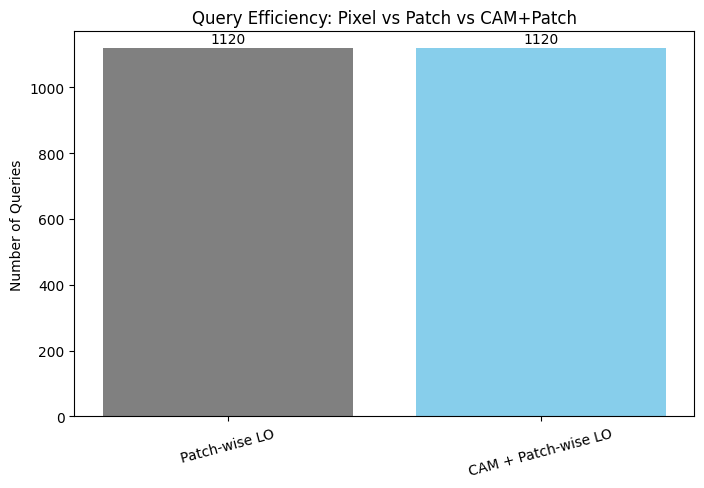

In [ ]:
results_lo = compare_label_only_attack(x_orig, x_target, target_label, cam_mask)
plot_query_comparison(results_lo)


In [ ]:
def temperature_schedule(current_step, total_steps, epsilon_init, epsilon_final, strategy="cosine"):
    """Return temperature-scaled epsilon for current step"""
    if strategy == "cosine":
        factor = 0.5 * (1 + np.cos(np.pi * current_step / total_steps))
    elif strategy == "linear":
        factor = 1 - (current_step / total_steps)
    else:
        raise ValueError("Unsupported strategy")
    return epsilon_final + (epsilon_init - epsilon_final) * factor


In [ ]:
def query_limited_attack_patchwise_temp(
    x_orig, target_label, epsilon_init=1.0, epsilon_final=0.05,
    sigma=0.005, step_size=0.01, n_samples=50, max_queries=2000,
    query_model_fn=None, cam_mask=None, patch_size=32
):
    x_adv = x_orig.clone().detach()
    num_queries = 0

    def proxy_objective(x):
        preds = query_model_fn(x, return_probs=False).tolist()
        preds = preds[0] if isinstance(preds[0], list) else preds
        return -int(target_label in preds)

    total_steps = max_queries // (n_samples + 1)

    for step in range(total_steps):
        epsilon = temperature_schedule(step, total_steps, epsilon_init, epsilon_final)

        grad = nes_gradient_estimate_patchwise_weighted(
            x_adv, proxy_objective,
            cam_mask if cam_mask is not None else torch.ones_like(x_orig[:, :1]),
            patch_size, sigma, n_samples
        )

        num_queries += n_samples

        x_adv = x_adv + step_size * torch.sign(grad)
        x_adv = clip(x_adv, x_orig, epsilon)

        preds = query_model_fn(x_adv, return_probs=False).tolist()
        preds = preds[0] if isinstance(preds[0], list) else preds
        num_queries += 1
        if target_label not in preds:
            return x_adv, False, num_queries

        if num_queries >= max_queries:
            break

    return x_adv, True, num_queries


In [ ]:
def visualize_patchwise_querylimited_temp(x_orig, x_adv, patch_size=32, title="Query-Limited NES Attack (Temp Scheduling)"):
    x_orig = x_orig.squeeze()
    x_adv = x_adv.squeeze()

    # Unnormalize for display
    x_orig_disp = unnormalize(x_orig).permute(1, 2, 0).cpu().numpy()
    x_adv_disp = unnormalize(x_adv).permute(1, 2, 0).cpu().numpy()

    # Compute absolute difference heatmap
    diff_map = (x_adv - x_orig).abs().sum(dim=0).cpu().numpy()

    H, W = diff_map.shape
    patch_map = np.zeros((H // patch_size, W // patch_size))
    for i in range(0, H, patch_size):
        for j in range(0, W, patch_size):
            patch_value = diff_map[i:i+patch_size, j:j+patch_size].mean()
            patch_map[i // patch_size, j // patch_size] = patch_value

    patch_map = patch_map / patch_map.max()

    # Plot all views
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    axs[0].imshow(x_orig_disp)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(x_adv_disp)
    axs[1].set_title("Adversarial Image")
    axs[1].axis("off")

    axs[2].imshow((x_adv_disp - x_orig_disp).mean(axis=2), cmap='bwr')
    axs[2].set_title("Pixel-wise Difference")
    axs[2].axis("off")

    im = axs[3].imshow(patch_map, cmap="hot", interpolation="nearest")
    axs[3].set_title("Patch Perturbation")
    axs[3].axis("off")
    fig.colorbar(im, ax=axs[3], shrink=0.7, label="Avg Patch Change")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


Attack Success: Yes
Queries Used: 1989


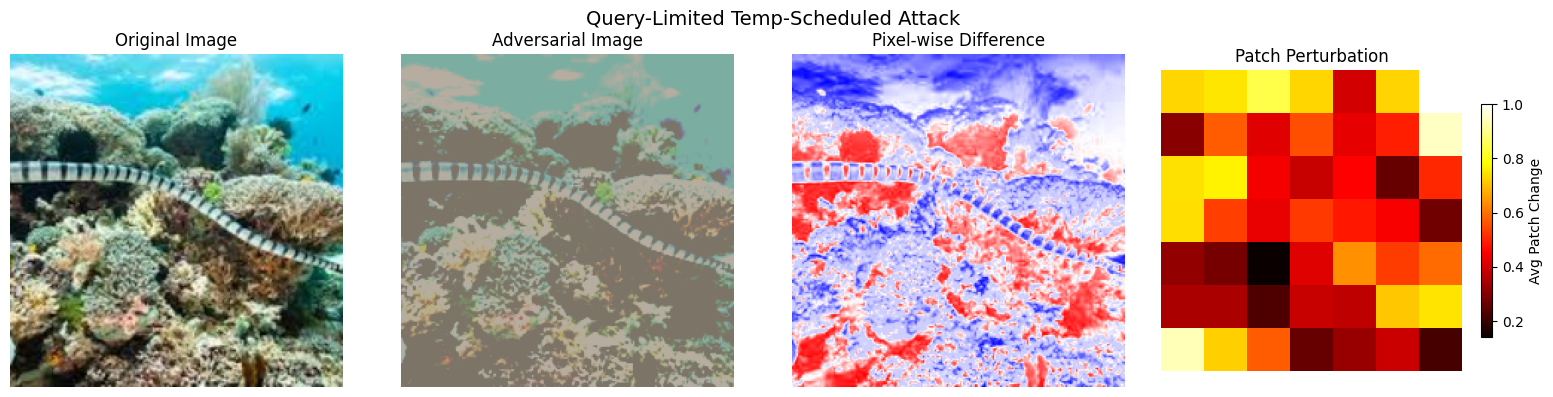

In [ ]:
# Example usage
x_adv_temp, success_temp, queries_temp = query_limited_attack_patchwise_temp(
    x_orig=x_orig,                      # original image tensor (1, C, H, W)
    target_label=target_label,         # the target label for the attack
    epsilon_init=1.0,
    epsilon_final=0.05,
    sigma=0.005,
    step_size=0.01,
    n_samples=50,
    max_queries=2000,
    query_model_fn=query_model,     # your queryable model interface
    cam_mask=None,                     # or pass a valid mask if needed
    patch_size=32
)

print("Attack Success:", "Yes" if success_temp else "No")
print("Queries Used:", queries_temp)

# Visualize result
visualize_patchwise_querylimited_temp(
    x_orig, x_adv_temp, patch_size=32,
    title="Query-Limited Temp-Scheduled Attack"
)


In [ ]:
def plot_query_comparison(query_std, query_temp, success_std=True, success_temp=True):
    methods = ['Standard NES', 'Temp-Scheduled NES']
    queries = [query_std, query_temp]
    colors = ['skyblue', 'salmon']

    plt.figure(figsize=(6, 4))
    bars = plt.bar(methods, queries, color=colors)

    # Add success or failure annotation
    for i, bar in enumerate(bars):
        yval = bar.get_height()
        label = "✓" if (success_std if i == 0 else success_temp) else "✗"
        plt.text(bar.get_x() + bar.get_width()/2, yval + 10, f"{int(yval)} Q\n{label}",
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.ylabel("Number of Queries")
    plt.title("Query Count Comparison")
    plt.ylim(0, max(queries) * 1.2)
    plt.tight_layout()
    plt.show()


In [ ]:
x_adv_std, success_std, queries_std = query_limited_attack_patchwise(...)  # existing one
x_adv_temp, success_temp, queries_temp = query_limited_attack_patchwise_temp(...)  # new temp one

# Visuals
visualize_patchwise_nocam_perturbation(x_orig, x_adv_std, patch_size=32, title="Standard NES Attack")
visualize_patchwise_querylimited_temp(x_orig, x_adv_temp, patch_size=32, title="Temp-Scheduled NES Attack")

# Plot comparison
plot_query_comparison(queries_std, queries_temp, success_std, success_temp)


TypeError: query_limited_attack_patchwise() missing 7 required positional arguments: 'target_label', 'epsilon', 'sigma', 'step_size', 'n_samples', 'max_queries', and 'query_model_fn'

In [ ]:
def partial_info_attack_patchwise_temp(
    x_orig, x_target, target_label, epsilon_init=1.0, epsilon_final=0.05,
    decay_rate=0.98, shrink_steps=100, sigma=0.005, step_size=0.01,
    n_samples=50, max_queries=2000, query_model_fn=None, topk=5,
    cam_mask=None, patch_size=32
):
    x_adv = x_target.clone().detach()
    epsilon = epsilon_init
    num_queries = 0

    for i in range(shrink_steps):
        topk_preds = query_model_fn(x_adv, return_probs=False).tolist()
        topk_preds = [topk_preds] if isinstance(topk_preds, int) else topk_preds
        num_queries += 1

        if target_label in topk_preds:
            direction = torch.sign(x_adv - x_orig)
            x_adv = x_adv - step_size * direction
            x_adv = clip(x_adv, x_orig, epsilon)
            epsilon = max(epsilon * decay_rate, epsilon_final)
        else:
            break

    def proxy_objective(x):
        preds = query_model_fn(x, return_probs=False).tolist()
        preds = preds[0] if isinstance(preds[0], list) else preds
        return topk - preds.index(target_label) if target_label in preds else 0

    for step in range(20):
        epsilon = temperature_schedule(step, 20, epsilon_init, epsilon_final)

        grad = nes_gradient_estimate_patchwise_weighted(
            x_adv, proxy_objective,
            cam_mask if cam_mask is not None else torch.ones_like(x_orig[:, :1]),
            patch_size, sigma, n_samples
        )

        num_queries += n_samples
        x_adv = x_adv + step_size * torch.sign(grad)
        x_adv = clip(x_adv, x_orig, epsilon)

        preds = query_model_fn(x_adv, return_probs=False).tolist()
        preds = preds[0] if isinstance(preds[0], list) else preds
        num_queries += 1

        if target_label not in preds:
            return x_adv, False, num_queries

    return x_adv, True, num_queries


In [ ]:
def label_only_attack_patchwise_temp(
    x_orig, x_target, target_label, epsilon_init=1.0, epsilon_final=0.05,
    decay_rate=0.98, shrink_steps=100, sigma=0.005, step_size=0.01,
    n_samples=50, max_queries=2000, query_model_fn=None, topk=5,
    cam_mask=None, patch_size=32
):
    x_adv = x_target.clone().detach()
    epsilon = epsilon_init
    num_queries = 0

    for i in range(shrink_steps):
        topk_preds = query_model_fn(x_adv, return_probs=False).tolist()
        if isinstance(topk_preds, int):
            topk_preds = [topk_preds]
        num_queries += 1

        if target_label in topk_preds:
            direction = torch.sign(x_adv - x_orig)
            x_adv = x_adv - step_size * direction
            x_adv = clip(x_adv, x_orig, epsilon)
            epsilon = max(epsilon * decay_rate, epsilon_final)
        else:
            break

    def proxy_objective(x):
        preds = query_model_fn(x, return_probs=False).tolist()
        if isinstance(preds, int):
            preds = [preds]
        return topk - preds.index(target_label) if target_label in preds else 0

    for step in range(20):
        epsilon = temperature_schedule(step, 20, epsilon_init, epsilon_final)

        grad = nes_gradient_estimate_patchwise_weighted(
            x_adv, proxy_objective,
            cam_mask if cam_mask is not None else torch.ones_like(x_orig[:, :1]),
            patch_size, sigma, n_samples
        )

        num_queries += n_samples
        x_adv = x_adv + step_size * torch.sign(grad)
        x_adv = clip(x_adv, x_orig, epsilon)

        preds = query_model_fn(x_adv, return_probs=False).tolist()
        if isinstance(preds, int):
            preds = [preds]
        num_queries += 1

        if target_label not in preds:
            return x_adv, False, num_queries

    return x_adv, True, num_queries
